Optimized bike rental demand forecasting using regression models (OLS, CART, RF, XGBoost); achieved 45%+ reduction in RMSE from baseline by tuning tree-based models and comparing pruning vs ensemble performance. Benchmarked GridSearchCV vs RandomizedSearchCV to evaluate tuning efficiency.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/JPProjects/rentals_weather.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rentals        8603 non-null   int64  
 1   month          8603 non-null   int64  
 2   day            8603 non-null   int64  
 3   hour           8603 non-null   int64  
 4   day_of_week    8603 non-null   object 
 5   weekend        8603 non-null   int64  
 6   temp           8603 non-null   int64  
 7   temp_wb        8603 non-null   int64  
 8   rel_humidity   8603 non-null   int64  
 9   windspeed      8603 non-null   int64  
 10  precipitation  8603 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 739.4+ KB


In [5]:
# which variables need to be treated as categorical
categoricals = ['month', 'day', 'hour', 'day_of_week', 'weekend']
df[categoricals] = df[categoricals].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   rentals        8603 non-null   int64   
 1   month          8603 non-null   category
 2   day            8603 non-null   category
 3   hour           8603 non-null   category
 4   day_of_week    8603 non-null   category
 5   weekend        8603 non-null   category
 6   temp           8603 non-null   int64   
 7   temp_wb        8603 non-null   int64   
 8   rel_humidity   8603 non-null   int64   
 9   windspeed      8603 non-null   int64   
 10  precipitation  8603 non-null   float64 
dtypes: category(5), float64(1), int64(5)
memory usage: 448.3 KB


In [6]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)
X_train = df_train.copy()
y_train = X_train.pop('rentals')
X_test = df_test.copy()
y_test = X_test.pop('rentals')

### Metrics

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def OSR2(y_pred, y_true, training_mean):
  '''
  Calculates out-of-sample R-squared
  '''
  baseline_error = np.sum(np.square((training_mean - y_true)))
  model_error = np.sum(np.square((y_pred - y_true)))
  return 1.0 - model_error/baseline_error

def calc_metrics(y_pred=y_pred,y_test=y_test,y_train = y_train):
  print(f'OSR2: {OSR2(y_pred,y_test, y_train.mean()):.3f}')
  print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
  print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')


## Linear Regression using OLS

In [33]:
my_formula = 'rentals ~ ' + '+'.join(df.columns[1:])
print(my_formula)
from statsmodels.formula.api import ols
est = ols(formula = my_formula, data=df_train).fit()

rentals ~ month+day+hour+day_of_week+weekend+temp+temp_wb+rel_humidity+windspeed+precipitation


In [34]:
y_pred = est.predict(X_test)
calc_metrics(y_pred,y_test,y_train)

OSR2: 0.683
MAE: 90.685
RMSE: 124.866


## Linear Regression using SciKit Learn

In [35]:
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()
X_train_sc = pd.get_dummies(X_train_sc,columns =categoricals,drop_first=True)
X_test_sc = pd.get_dummies(X_test_sc,columns =categoricals,drop_first=True)


In [36]:
X_train_sc.head(1)

,temp,temp_wb,rel_humidity,windspeed,precipitation,month_2,month_3,month_4,month_5,month_6,...,hour_21,hour_22,hour_23,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,weekend_1
5156,84,74,61,10,0.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [37]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)
calc_metrics(y_pred,y_test,y_train)

OSR2: 0.683
MAE: 90.685
RMSE: 124.866


## Linear Regression using CART

In [59]:
from sklearn.tree import DecisionTreeRegressor

In [60]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_sc,y_train)
y_pred_tree = tree.predict(X_test_sc)
calc_metrics(y_pred_tree,y_test,y_train)

OSR2: 0.767
MAE: 62.226
RMSE: 107.102


In [61]:
tree.tree_.node_count, tree.tree_.max_depth # its a huge tree

(11321, 47)

## CART with CCP

In [62]:
path = tree.cost_complexity_pruning_path(X_train_sc,y_train)
alphas = path.ccp_alphas
len(alphas)

5170

In [63]:
alphas_small = alphas[::100] # Keep fewer alpha
alphas_small = alphas_small[::-1]# go from largest to smallest alpha


In [64]:
r2_all = []
osr2_all = []
node_counts = []

for alpha in alphas_small:
  tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
  tree.fit(X_train_sc,y_train)
  y_pred = tree.predict(X_train_sc)
  # OSR on training can be used to detect overfitting; IFF OSR > .99=-> OVERFIT
  #| OSR² (Train) | OSR² (Test) | Interpretation              |
  #| > 0.99       | < 0.5       | 🚨 Overfit (high variance)  |
  #| \~0.7        | \~0.65      | ✅ Good generalization       |
  #| Low both     | Low both    | ❌ Underfit or weak features |
  r2_all.append(OSR2(y_pred, y_train, y_train.mean()))
  y_pred = tree.predict(X_test_sc)
  osr2_all.append(OSR2(y_pred, y_test, y_train.mean()))
  node_counts.append(tree.tree_.node_count)

Text(0.5, 1.0, 'Prediction quality vs tree size')

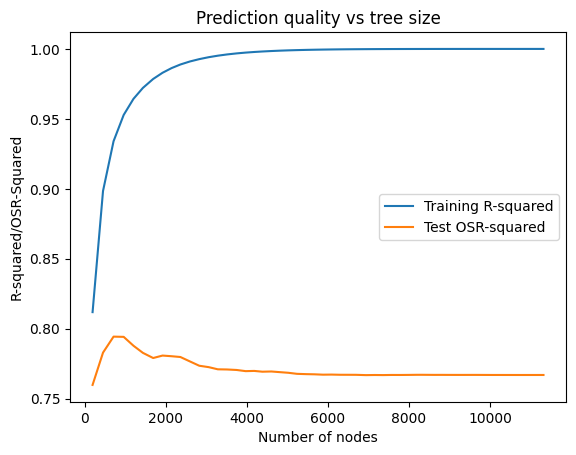

In [49]:
plt.plot(node_counts, r2_all, label='Training R-squared')
plt.plot(node_counts, osr2_all, label='Test OSR-squared')
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('R-squared/OSR-Squared')
plt.title('Prediction quality vs tree size')

In [65]:
opt_idx = np.argmax(osr2_all)
print(opt_idx)
osr2_all[:4]

2


[np.float64(0.7598469435100529),
 np.float64(0.782939335146191),
 np.float64(0.7943605846412988),
 np.float64(0.7941964554091118)]

In [66]:
tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alphas_small[opt_idx])
tree.fit(X_train_sc,y_train)

DecisionTreeRegressor(ccp_alpha=np.float64(10.085693199010924), random_state=42)

In [67]:
tree.tree_.node_count, tree.tree_.max_depth

(707, 28)

In [68]:
y_pred_tree = tree.predict(X_test_sc)
calc_metrics(y_pred_tree,y_test,y_train)

OSR2: 0.794
MAE: 61.250
RMSE: 100.607


## Random Forests

In [70]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
rf = RandomForestRegressor(random_state=42).fit(X_train_sc,y_train)
y_pred = rf.predict(X_test_sc)
calc_metrics(y_pred,y_test,y_train)

OSR2: 0.881
MAE: 47.341
RMSE: 76.512


## **XGBoost**

In [75]:
import xgboost
print(xgboost.__version__)
from xgboost import XGBRegressor

2.1.4


In [77]:
model = XGBRegressor(random_state=42)
model.fit(X_train_sc,y_train)
y_pred = model.predict(X_test_sc)
calc_metrics(y_pred,y_test,y_train)

OSR2: 0.903
MAE: 44.606
RMSE: 68.990


## XGBoost with GridSearch CV

In [78]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10,50,100],
              'max_depth': [1,2,3,4,5],
              'learning_rate': [0.001, 0.01, 0.1, 0.3]}
model = XGBRegressor(random_state=42)

In [79]:
gcv = GridSearchCV(model,
                  param_grid=param_grid,
                  cv=5,
                  scoring='neg_mean_absolute_error')
gcv.fit(X_train_sc,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_mean_absolute_error')

In [80]:
gcv.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}

In [81]:
y_pred = gcv.best_estimator_.predict(X_test_sc)
calc_metrics(y_pred,y_test,y_train)

OSR2: 0.898
MAE: 46.431
RMSE: 71.007


## XGBoost with RandomSearch CV

In [82]:
from sklearn.model_selection import RandomizedSearchCV

In [83]:
model = XGBRegressor(random_state=42)
param_grid = {'n_estimators': range(10,1010,10),
              'max_depth': range(1,21),
              'learning_rate': np.linspace(0.001, 1.0, 50)}

In [84]:
rcv = RandomizedSearchCV(model,
                        param_distributions = param_grid,
                        cv=5,
                        n_iter=10,
                        scoring='neg_mean_absolute_error',
                        random_state=42)

In [85]:
rcv.fit(X_train_sc,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       0.51069388, 0.53108163, 0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
                                        'max_depth': range(1, 21),
                                        'n_estimators': range(10, 1010, 10)},
                   random_state=42, scoring='neg_mean_absolute_error')

In [86]:
rcv.best_params_

{'n_estimators': 960,
 'max_depth': 18,
 'learning_rate': np.float64(0.1437142857142857)}

In [87]:
y_pred = rcv.best_estimator_.predict(X_test_sc)
calc_metrics(y_pred,y_test,y_train)

OSR2: 0.884
MAE: 44.677
RMSE: 75.596


### 🚲 Bike Rentals Regression: Model Comparison Summary

| Model                        | OSR²   | MAE     | RMSE    |
|-----------------------------|--------|---------|---------|
| OLS                         | 0.683  | 90.685  | 124.866 |
| Scikit-learn LinearRegression | 0.683  | 90.685  | 124.866 |
| CART (Default)              | 0.767  | 62.226  | 107.102 |
| CART (Pruned with CCP)      | 0.794  | 61.250  | 100.607 |
| Random Forest               | 0.881  | 47.341  | 76.512  |
| XGBoost                     | 0.903  | 44.606  | 68.990  |
| XGBoost (GridSearchCV)      | 0.898  | 46.431  | 71.007  |
| XGBoost (RandomizedSearchCV)| 0.884  | 44.677  | 75.596  |
